In [62]:
# ==== Yearly-stack quick viewer  =========================================
from pathlib import Path
import rasterio
import matplotlib.pyplot as plt

def read(path: Path, bands: list[int] = None):
    # -------------------------------------------------------------------------
    # 1) Choose the file and bands to display
    stack_path = Path(path)  # <- edit
    bands_to_show = [69]   # e.g. [1, 5, 12] or [] for none
    # -------------------------------------------------------------------------

    with rasterio.open(stack_path) as src:
        print("=== FILE METADATA ===")
        print(f"Name       : {stack_path.name}")
        print(f"Size       : {src.width} × {src.height}")
        print(f"Bands      : {src.count}")
        print(f"CRS        : {src.crs}")
        print(f"Transform  : {src.transform}\n")

        print("=== BAND DESCRIPTIONS ===")
        for i, desc in enumerate(src.descriptions, 1):
            print(f"{i:>3}: {desc}")

        # default to first three bands if list empty
        if not bands_to_show:
            bands_to_show = list(range(1, min(4, src.count + 1)))

        for b in bands_to_show:
            if 1 <= b <= src.count:
                arr = src.read(b)
                desc = src.descriptions[b-1] or f"Band {b}"
                plt.figure(figsize=(12, 10))
                plt.title(f"{desc}  (band {b})")
                plt.imshow(arr, cmap="viridis")
                plt.axis("off")
            else:
                print(f"⚠️  Band {b} is out of range (1–{src.count}).")
    plt.tight_layout()
    plt.show()
    # ========================================================================

=== FILE METADATA ===
Name       : yearly_2005.tif
Size       : 192 × 198
Bands      : 244
CRS        : EPSG:3857
Transform  : | 9265.00, 0.00,-1899325.00|
| 0.00,-9265.00, 4271165.00|
| 0.00, 0.00, 1.00|

=== BAND DESCRIPTIONS ===
  1: soilgrids_bdod_bdod_0-5cm_mean
  2: soilgrids_bdod_bdod_100-200cm_mean
  3: soilgrids_bdod_bdod_15-30cm_mean
  4: soilgrids_bdod_bdod_30-60cm_mean
  5: soilgrids_bdod_bdod_5-15cm_mean
  6: soilgrids_bdod_bdod_60-100cm_mean
  7: soilgrids_cec_cec_0-5cm_mean
  8: soilgrids_cec_cec_100-200cm_mean
  9: soilgrids_cec_cec_15-30cm_mean
 10: soilgrids_cec_cec_30-60cm_mean
 11: soilgrids_cec_cec_5-15cm_mean
 12: soilgrids_cec_cec_60-100cm_mean
 13: soilgrids_cfvo_cfvo_0-5cm_mean
 14: soilgrids_cfvo_cfvo_100-200cm_mean
 15: soilgrids_cfvo_cfvo_15-30cm_mean
 16: soilgrids_cfvo_cfvo_30-60cm_mean
 17: soilgrids_cfvo_cfvo_5-15cm_mean
 18: soilgrids_cfvo_cfvo_60-100cm_mean
 19: soilgrids_clay_clay_0-5cm_mean
 20: soilgrids_clay_clay_100-200cm_mean
 21: soilgrids_clay_

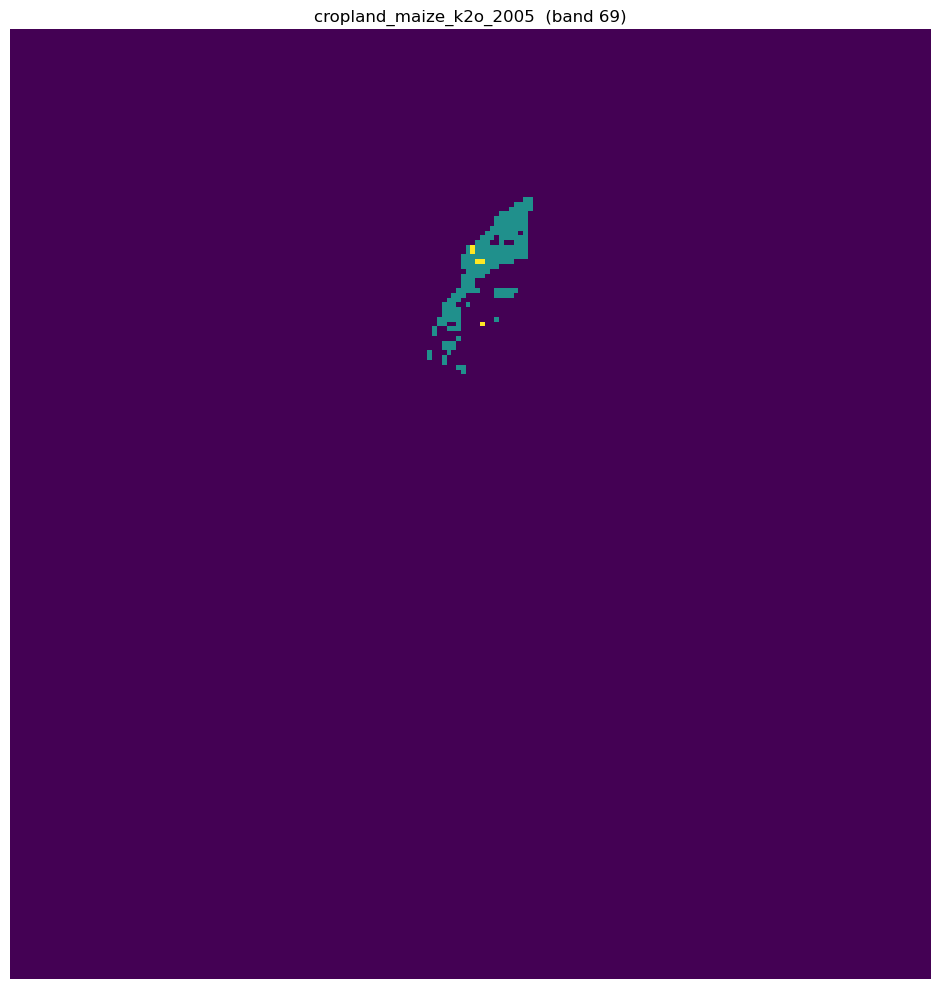

In [76]:
read("output/processed/stack_yearly/yearly_2005.tif")

In [ ]:
read("output/GlobalCropYield5min_Morocco/Maize_2001.tif")

In [ ]:
read("/data/oe23/fert-recon/output/Cropland_Maps_Morocco/Maize_K2O_2000.tiff")

In [ ]:
# ---------- paths ----------
REF_FP       = "output/processed/stack_yearly/yearly_2005.tif"
CANDIDATE_FP = "/data/oe23/fert-recon/output/Cropland_Maps_Morocco/Maize_K2O_2000.tiff"
REF_BAND     = 4
CAND_BAND    = 1

# ---------- code ----------
import numpy as np, rasterio, matplotlib.pyplot as plt
from rasterio.warp  import reproject, Resampling
from rasterio.plot  import show
from pathlib import Path

with rasterio.open(REF_FP) as ref, rasterio.open(CANDIDATE_FP) as cand:
    # 1) read & contrast-stretch the reference band
    ref_arr = ref.read(REF_BAND).astype("float32")
    finite  = ref_arr[(ref_arr != ref.nodata) & (ref_arr != 0)]
    vmin, vmax = np.percentile(finite, (2, 98)) if finite.size else (0, 1)
    ref_vis    = np.clip((ref_arr - vmin) / (vmax - vmin), 0, 1)

    # 2) resample candidate onto reference grid
    cand_on_ref = np.zeros_like(ref_arr, dtype="uint8")
    reproject(
        rasterio.band(cand, CAND_BAND), cand_on_ref,
        src_transform=cand.transform, src_crs=cand.crs,
        dst_transform=ref.transform,  dst_crs=ref.crs,
        resampling=Resampling.nearest, dst_nodata=0
    )
    mask = cand_on_ref != 0            # candidate footprint

    print("candidate pixels on ref grid:", int(mask.sum()))

    # 3) side-by-side panels
    fig, axs = plt.subplots(1, 3, figsize=(30, 10))

    # --- panel 1: reference ---
    show(ref_vis, transform=ref.transform, cmap="gray", ax=axs[0])
    axs[0].set_title("Reference")

    # --- panel 2: candidate resampled ---
    show(np.where(mask, cand_on_ref, np.nan),
         transform=ref.transform, cmap="viridis", ax=axs[1])
    axs[1].set_title(Path(CANDIDATE_FP).name + "\n(resampled)")

    # --- panel 3: overlay ---
    show(ref_vis, transform=ref.transform, cmap="gray", ax=axs[2])
    show(np.where(mask, 1, np.nan), transform=ref.transform,
         cmap="Reds", ax=axs[2], alpha=0.6)
    axs[2].set_title("Overlay (footprint in red)")

    for a in axs: a.axis("off")
    plt.tight_layout()
    plt.savefig("output/processed/stack_yearly/overlay.png", dpi=300)
    plt.show()
# ========================================================================

## Cleaning

In [66]:
import pandas as pd
df = pd.read_csv("output/processed/stack_yearly/pixels_2002_2015.csv")

In [67]:
df

,pixel_id,year,soilgrids_bdod_bdod_0-5cm_mean,soilgrids_bdod_bdod_100-200cm_mean,soilgrids_bdod_bdod_15-30cm_mean,soilgrids_bdod_bdod_30-60cm_mean,soilgrids_bdod_bdod_5-15cm_mean,soilgrids_bdod_bdod_60-100cm_mean,soilgrids_cec_cec_0-5cm_mean,soilgrids_cec_cec_100-200cm_mean,...,terraclimate_vs_mean_2002,terraclimate_vs_min_2002,terraclimate_vs_p25_2002,terraclimate_vs_p50_2002,terraclimate_vs_p75_2002,terraclimate_vs_stddev_2002,yield_maize_2002,yield_rice_2002,yield_soybean_2002,yield_wheat_2002
0,0,2002,-32768,-32768,-32768,-32768,-32768,-32768,-32768,-32768,...,0,0,0,0,0,0,0,0,0,0
1,1,2002,-32768,-32768,-32768,-32768,-32768,-32768,-32768,-32768,...,0,0,0,0,0,0,0,0,0,0
2,2,2002,-32768,-32768,-32768,-32768,-32768,-32768,-32768,-32768,...,0,0,0,0,0,0,0,0,0,0
3,3,2002,-32768,-32768,-32768,-32768,-32768,-32768,-32768,-32768,...,0,0,0,0,0,0,0,0,0,0
4,4,2002,-32768,-32768,-32768,-32768,-32768,-32768,-32768,-32768,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532219,38011,2015,151,154,153,153,152,154,250,286,...,374,303,334,366,413,53,0,0,0,0
532220,38012,2015,151,154,152,152,152,154,255,291,...,378,300,343,372,421,53,0,0,0,0
532221,38013,2015,151,157,153,154,153,156,251,284,...,377,292,339,370,421,56,0,0,0,0
532222,38014,2015,152,155,154,153,154,154,248,284,...,378,298,336,368,426,56,0,0,0,0


In [ ]:
list(df.columns)

In [ ]:
land = df["modis_mcd12q1_2002_01_01.lc_prop1_2002"] != 3
df_land = df[land]
print("Rows after masking:", len(df_land))

Rows after masking: 345236


In [84]:
df_land[df_land['pixel_id']==134]

,pixel_id,year,soilgrids_bdod_bdod_0-5cm_mean,soilgrids_bdod_bdod_100-200cm_mean,soilgrids_bdod_bdod_15-30cm_mean,soilgrids_bdod_bdod_30-60cm_mean,soilgrids_bdod_bdod_5-15cm_mean,soilgrids_bdod_bdod_60-100cm_mean,soilgrids_cec_cec_0-5cm_mean,soilgrids_cec_cec_100-200cm_mean,soilgrids_cec_cec_15-30cm_mean,soilgrids_cec_cec_30-60cm_mean,soilgrids_cec_cec_5-15cm_mean,soilgrids_cec_cec_60-100cm_mean,soilgrids_cfvo_cfvo_0-5cm_mean,soilgrids_cfvo_cfvo_100-200cm_mean,soilgrids_cfvo_cfvo_15-30cm_mean,soilgrids_cfvo_cfvo_30-60cm_mean,soilgrids_cfvo_cfvo_5-15cm_mean,soilgrids_cfvo_cfvo_60-100cm_mean,soilgrids_clay_clay_0-5cm_mean,soilgrids_clay_clay_100-200cm_mean,soilgrids_clay_clay_15-30cm_mean,soilgrids_clay_clay_30-60cm_mean,soilgrids_clay_clay_5-15cm_mean,soilgrids_clay_clay_60-100cm_mean,soilgrids_nitrogen_nitrogen_0-5cm_mean,soilgrids_nitrogen_nitrogen_100-200cm_mean,soilgrids_nitrogen_nitrogen_15-30cm_mean,soilgrids_nitrogen_nitrogen_30-60cm_mean,soilgrids_nitrogen_nitrogen_5-15cm_mean,soilgrids_nitrogen_nitrogen_60-100cm_mean,soilgrids_ocd_ocd_0-5cm_mean,soilgrids_ocd_ocd_100-200cm_mean,soilgrids_ocd_ocd_15-30cm_mean,soilgrids_ocd_ocd_30-60cm_mean,soilgrids_ocd_ocd_5-15cm_mean,soilgrids_ocd_ocd_60-100cm_mean,soilgrids_phh2o_phh2o_0-5cm_mean,soilgrids_phh2o_phh2o_100-200cm_mean,soilgrids_phh2o_phh2o_15-30cm_mean,soilgrids_phh2o_phh2o_30-60cm_mean,soilgrids_phh2o_phh2o_5-15cm_mean,soilgrids_phh2o_phh2o_60-100cm_mean,soilgrids_sand_sand_0-5cm_mean,soilgrids_sand_sand_100-200cm_mean,soilgrids_sand_sand_15-30cm_mean,soilgrids_sand_sand_30-60cm_mean,soilgrids_sand_sand_5-15cm_mean,soilgrids_sand_sand_60-100cm_mean,soilgrids_silt_silt_0-5cm_mean,soilgrids_silt_silt_100-200cm_mean,soilgrids_silt_silt_15-30cm_mean,soilgrids_silt_silt_30-60cm_mean,soilgrids_silt_silt_5-15cm_mean,soilgrids_silt_silt_60-100cm_mean,globalsurfacewater.change_abs_2002,globalsurfacewater.change_norm_2002,globalsurfacewater.max_extent_2002,globalsurfacewater.occurrence_2002,globalsurfacewater.recurrence_2002,globalsurfacewater.seasonality_2002,globalsurfacewater.transition_2002,chirps_precip_max_2002,chirps_precip_mean_2002,chirps_precip_p25_2002,chirps_precip_p50_2002,chirps_precip_p75_2002,chirps_precip_stddev_2002,chirps_precip_sum_2002,cropland_maize_k2o_2002,cropland_maize_n_2002,cropland_maize_p2o5_2002,cropland_rice_k2o_2002,cropland_rice_n_2002,cropland_rice_p2o5_2002,cropland_soybean_k2o_2002,cropland_soybean_n_2002,cropland_soybean_p2o5_2002,cropland_wheat_k2o_2002,cropland_wheat_n_2002,cropland_wheat_p2o5_2002,era5_temp_max_2002,era5_temp_mean_2002,era5_temp_p25_2002,era5_temp_p50_2002,era5_temp_p75_2002,era5_temp_stddev_2002,modis_lai_fapar_fpar_max_2002,modis_lai_fapar_fpar_mean_2002,modis_lai_fapar_fpar_min_2002,modis_lai_fapar_fpar_p25_2002,modis_lai_fapar_fpar_p50_2002,modis_lai_fapar_fpar_p75_2002,modis_lai_fapar_fpar_stddev_2002,modis_lai_fapar_lai_max_2002,modis_lai_fapar_lai_mean_2002,modis_lai_fapar_lai_min_2002,modis_lai_fapar_lai_p25_2002,modis_lai_fapar_lai_p50_2002,modis_lai_fapar_lai_p75_2002,modis_lai_fapar_lai_stddev_2002,modis_lst_lst_day_1km_max_2002,modis_lst_lst_day_1km_mean_2002,modis_lst_lst_day_1km_min_2002,modis_lst_lst_day_1km_p25_2002,modis_lst_lst_day_1km_p50_2002,modis_lst_lst_day_1km_p75_2002,modis_lst_lst_day_1km_stddev_2002,modis_lst_lst_night_1km_max_2002,modis_lst_lst_night_1km_mean_2002,modis_lst_lst_night_1km_min_2002,modis_lst_lst_night_1km_p25_2002,modis_lst_lst_night_1km_p50_2002,modis_lst_lst_night_1km_p75_2002,modis_lst_lst_night_1km_stddev_2002,modis_mcd12q1_2002_01_01.lc_prop1_2002,modis_mcd12q1_2002_01_01.lc_prop1_assessment_2002,modis_mcd12q1_2002_01_01.lc_prop2_2002,modis_mcd12q1_2002_01_01.lc_prop2_assessment_2002,modis_mcd12q1_2002_01_01.lc_prop3_2002,modis_mcd12q1_2002_01_01.lc_prop3_assessment_2002,modis_mcd12q1_2002_01_01.lc_type1_2002,modis_mcd12q1_2002_01_01.lc_type2_2002,modis_mcd12q1_2002_01_01.lc_type3_2002,modis_mcd12q1_2002_01_01.lc_type4_2002,modis_mcd12q1_2002_01_01.lc_type5_2002,modis_mcd12

In [91]:
df_land

,pixel_id,year,soilgrids_bdod_bdod_0-5cm_mean,soilgrids_bdod_bdod_100-200cm_mean,soilgrids_bdod_bdod_15-30cm_mean,...,terraclimate_vs_stddev_2002,yield_maize_2002,yield_rice_2002,yield_soybean_2002,yield_wheat_2002
134,134,2002,131,153,140,...,46,0,0,0,1888
136,136,2002,132,156,143,...,45,0,0,0,1908
137,137,2002,132,155,142,...,38,0,0,0,1584
138,138,2002,129,153,140,...,38,0,0,0,1908
139,139,2002,131,154,142,...,38,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
532219,38011,2015,151,154,153,...,53,0,0,0,0
532220,38012,2015,151,154,152,...,53,0,0,0,0
532221,38013,2015,151,157,153,...,56,0,0,0,0
532222,38014,2015,152,155,154,...,56,0,0,0,0


In [90]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 10)

## Feature Importance

In [93]:
# feature_importance_yields.py
# ────────────────────────────
# prerequisites:
#   pip install scikit-learn pandas pyarrow joblib tqdm

import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from joblib import dump
from tqdm.auto import tqdm

# ------------------------------------------------------------------
# 1) load the pixel-year table  (≈ 250 MB in memory)
# ------------------------------------------------------------------
df = pd.read_csv(
    Path("output/processed/stack_yearly/pixels_2002_2015.csv")
)

# drop obvious non-predictors
X = df.drop(columns=["pixel_id", "year",
                     "yield_maize_2002", "yield_rice_2002",
                     "yield_soybean_2002", "yield_wheat_2002"]
            )                     # 244-4 = 240 predictors
feature_names = X.columns.tolist()

# ------------------------------------------------------------------
# 2) loop over each target
# ------------------------------------------------------------------
TARGETS = {
    "maize"   : "yield_maize_2002",
    "rice"    : "yield_rice_2002",
    "soybean" : "yield_soybean_2002",
    "wheat"   : "yield_wheat_2002",
}

results = {}

for crop, tgt_col in tqdm(TARGETS.items(), desc="RF training"):
    y = df[tgt_col].values
    X_train, X_val, y_train, y_val = train_test_split(
        X.values, y, test_size=0.2, random_state=42
    )

    rf = RandomForestRegressor(
        n_estimators=400,
        max_features="sqrt",
        n_jobs=-1,
        random_state=42,
        oob_score=True
    )
    rf.fit(X_train, y_train)

    print(f"\n{crop.upper():=^60}")
    print(" OOB R² :", rf.oob_score_)
    print(" Val R² :", r2_score(y_val, rf.predict(X_val)))

    # top-20 features
    importances = rf.feature_importances_
    order = importances.argsort()[::-1][:20]
    top = [(feature_names[i], importances[i]) for i in order]
    results[crop] = top

    # save model if you like
    dump(rf, f"rf_{crop}.joblib")

# ------------------------------------------------------------------
# 3) pretty-print the results
# ------------------------------------------------------------------
for crop, items in results.items():
    print(f"\n🌾 {crop.upper()}  —  Top 20 drivers")
    for rank, (feat, imp) in enumerate(items, 1):
        print(f"{rank:2d}. {feat:<45s}  {imp:0.4f}")


RF training:   0%|          | 0/4 [00:00<?, ?it/s]


===========================MAIZE============================
 OOB R² : 0.9713607608792874
 Val R² : 0.9706441022709947


RF training:  25%|██▌       | 1/4 [01:16<03:48, 76.27s/it]


============================RICE============================
 OOB R² : 1.0


RF training:  50%|█████     | 2/4 [01:38<01:28, 44.29s/it]

 Val R² : 1.0

==========================SOYBEAN===========================
 OOB R² : 1.0


RF training:  75%|███████▌  | 3/4 [01:59<00:34, 34.02s/it]

 Val R² : 1.0

===========================WHEAT============================
 OOB R² : 0.9600008864634872
 Val R² : 0.95897433585756


RF training: 100%|██████████| 4/4 [03:20<00:00, 50.01s/it]


🌾 MAIZE  —  Top 20 drivers
 1. cropland_maize_n_2002                          0.0959
 2. cropland_maize_p2o5_2002                       0.0637
 3. soilgrids_bdod_bdod_30-60cm_mean               0.0304
 4. soilgrids_bdod_bdod_100-200cm_mean             0.0299
 5. soilgrids_cec_cec_30-60cm_mean                 0.0283
 6. soilgrids_bdod_bdod_60-100cm_mean              0.0234
 7. soilgrids_cec_cec_100-200cm_mean               0.0208
 8. soilgrids_cec_cec_15-30cm_mean                 0.0189
 9. soilgrids_cec_cec_0-5cm_mean                   0.0174
10. cropland_wheat_n_2002                          0.0160
11. soilgrids_bdod_bdod_15-30cm_mean               0.0159
12. soilgrids_cec_cec_5-15cm_mean                  0.0157
13. soilgrids_cec_cec_60-100cm_mean                0.0150
14. soilgrids_bdod_bdod_5-15cm_mean                0.0132
15. modis_ndvi_evi_evi_stddev_2002                 0.0131
16. modis_ndvi_evi_ndvi_stddev_2002                0.0129
17. soilgrids_clay_clay_30-60cm_mean        

## New test

In [1]:
# ----- 0. data & helpers ----------------------------------
import pandas as pd, numpy as np, rasterio
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

df = pd.read_csv("output/processed/stack_yearly/pixels_2002_2015.csv")

# 1) land-mask
df = df[df["modis_mcd12q1_2002_01_01.lc_prop1_2002"] != 3]

# 2) drop ALL yield columns
yield_cols = [c for c in df if c.startswith("yield_")]
X = df.drop(columns=yield_cols + ["pixel_id"])

# 3) target
y = df["yield_maize_2002"]

# 4) train/test split by year  (train 2002-2014, test 2015)
train = X[df["year"] < 2015]
test  = X[df["year"] == 2015]
y_tr  = y[df["year"] < 2015]
y_te  = y[df["year"] == 2015]

rf = RandomForestRegressor(n_estimators=400, n_jobs=-1, random_state=42)
rf.fit(train, y_tr)
print("Test R²:", r2_score(y_te, rf.predict(test)))

# 5) permutation importance
perm = permutation_importance(rf, test, y_te, n_repeats=10, n_jobs=-1)
imp  = perm.importances_mean
order = imp.argsort()[::-1][:20]
for rank,i in enumerate(order,1):
    print(f"{rank:2d}. {train.columns[i]:50s}  {imp[i]:.4f}")


Test R²: 0.9616282138357577
 1. soilgrids_bdod_bdod_30-60cm_mean                    0.6538
 2. cropland_wheat_n_2002                               0.2848
 3. modis_lst_lst_day_1km_max_2002                      0.2680
 4. soilgrids_bdod_bdod_5-15cm_mean                     0.2245
 5. cropland_wheat_p2o5_2002                            0.2041
 6. soilgrids_bdod_bdod_100-200cm_mean                  0.1860
 7. soilgrids_cec_cec_30-60cm_mean                      0.1337
 8. soilgrids_phh2o_phh2o_0-5cm_mean                    0.1331
 9. cropland_maize_p2o5_2002                            0.1275
10. soilgrids_silt_silt_30-60cm_mean                    0.0944
11. soilgrids_nitrogen_nitrogen_0-5cm_mean              0.0897
12. cropland_maize_n_2002                               0.0836
13. terraclimate_vs_p75_2002                            0.0739
14. soilgrids_cec_cec_100-200cm_mean                    0.0738
15. soilgrids_silt_silt_100-200cm_mean                  0.0678
16. soilgrids_silt_silt_15-

In [ ]:
# feature_importance_lowmem.py
# ---------------------------------
import pandas as pd, numpy as np, gc, warnings
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

# ------------------------------------------------------------------
# 0) Load table  (Parquet preferred) and down-cast dtypes
# ------------------------------------------------------------------
parquet_fp = Path("output/processed/stack_yearly/pixels_2002_2015.parquet")
csv_fp     = Path("output/processed/stack_yearly/pixels_2002_2015.csv")

if parquet_fp.exists():
    df = pd.read_parquet(parquet_fp)
else:
    warnings.warn("Parquet not found – falling back to CSV (slower).")
    df = pd.read_csv(csv_fp)

# down-cast floats & ints to float32 / int32 to save RAM
for col, dt in df.dtypes.items():
    if dt == "float64":
        df[col] = df[col].astype("float32")
    elif dt == "int64":
        df[col] = df[col].astype("int32")

# ------------------------------------------------------------------
# 1) Land mask  (keep only class ≠ 3 → non-water)
# ------------------------------------------------------------------
land_mask = df["modis_mcd12q1_2002_01_01.lc_prop1_2002"] != 3
df = df[land_mask]

# ------------------------------------------------------------------
# 2) Remove all yield columns except the target
# ------------------------------------------------------------------
target_col = "yield_wheat_2002"
drop_yld = [c for c in df if c.startswith("yield_") and c != target_col]

X = df.drop(columns=drop_yld + ["pixel_id"]).copy()
y = df[target_col].copy()

# optional: SAMPLE rows to reduce memory & runtime
MAX_ROWS = 25_000
if len(X) > MAX_ROWS:
    samp = X.sample(n=MAX_ROWS, random_state=42).index
    X = X.loc[samp].reset_index(drop=True)
    y = y.loc[samp].reset_index(drop=True)

# free big original DataFrame
del df; gc.collect()

# ------------------------------------------------------------------
# 3) Train / test split by year
# ------------------------------------------------------------------
train_idx = X["year"] < 2015
test_idx  = X["year"] == 2015

X_train = X.loc[train_idx].drop(columns=["year"]).values
X_test  = X.loc[test_idx].drop(columns=["year"]).values
y_train = y.loc[train_idx].values
y_test  = y.loc[test_idx].values
feature_names = X.drop(columns=["year"]).columns.to_list()

# ------------------------------------------------------------------
# 4) Random-Forest model  (moderate size)
# ------------------------------------------------------------------
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42,
    oob_score=True
)
rf.fit(X_train, y_train)
print("Test R²:", r2_score(y_test, rf.predict(X_test)))

# ------------------------------------------------------------------
# 5) Permutation importance  – single process, small sample
# ------------------------------------------------------------------
perm = permutation_importance(
    rf,
    X_test,
    y_test,
    n_repeats=10,
    n_jobs=1,           # avoid multi-process temp files
    random_state=42,
    # max_samples=8_000   # evaluate on ≤8k rows
)

imp  = perm.importances_mean
order = imp.argsort()[::-1][:20]
print("\nTop 20 drivers for", target_col)
for rank, i in enumerate(order, 1):
    print(f"{rank:2d}. {feature_names[i]:50s}  {imp[i]:.4f}")


/tmp/ipykernel_1211724/1821070884.py:18: UserWarning: Parquet not found – falling back to CSV (slower).
  warnings.warn("Parquet not found – falling back to CSV (slower).")


Test R²: 0.9560880770715824


ValueError: max_samples must be <= n_samples

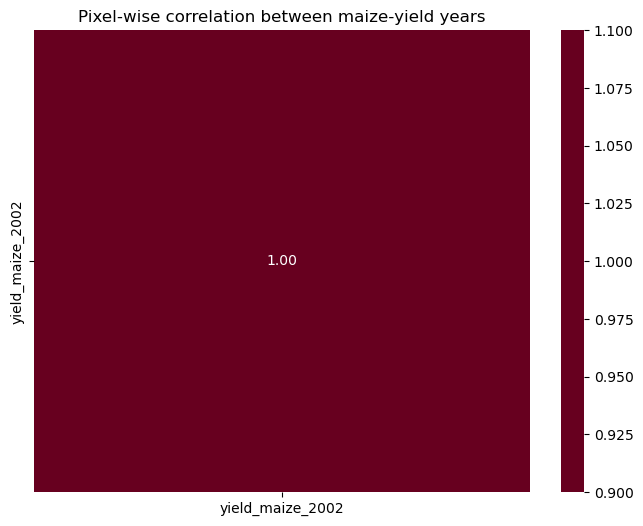

In [6]:
import pandas as pd
from pathlib import Path
import seaborn as sns, matplotlib.pyplot as plt

# load the DataFrame
df = pd.read_csv("output/processed/stack_yearly/pixels_2002_2015.csv")

# focus on maize yield columns only
maize_cols = [c for c in df.columns if c.startswith("yield_maize_")]
corr = df[maize_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu_r", center=0)
plt.title("Pixel-wise correlation between maize-yield years")
plt.show()


In [7]:
import numpy as np, rasterio
from tqdm.auto import tqdm

# reshape DataFrame back to (year, rows, cols)
years = range(2002, 2016)
rows, cols = 198, 192
cube = np.empty((len(years), rows, cols), dtype="float32")

for i,yr in enumerate(years):
    arr = df[df.year==yr].sort_values("pixel_id")["yield_maize_"+str(yr)].values
    cube[i] = arr.reshape(rows, cols)

# fit slope pixel-wise: y = a + b * year
Y = np.array(years)
b = np.polyfit(Y, cube.reshape(len(years), -1), deg=1)[0]   # slope per pixel
slope_map = b.reshape(rows, cols)

# write GeoTIFF (same geo as stacks)
with rasterio.open("output/processed/stack_yearly/yearly_2002.tif") as ref:
    meta = ref.meta.copy(); meta.update(count=1, dtype="float32")
    with rasterio.open("output/processed/slope_maize_2002_15.tif", "w", **meta) as dst:
        dst.write(slope_map, 1)


/data/oe23/ee/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyError: 'yield_maize_2003'

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# build X = yields 2002-2014, y = yield_2015
lag_cols = [f"yield_maize_{yr}" for yr in range(2002, 2015)]
X = df[df.year==2015][lag_cols]        # still per-pixel
y = df[df.year==2015]["yield_maize_2015"]

model = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=0)
model.fit(X, y)
print("R² predicting 2015 from lags:", model.score(X, y))
